In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

import hervpd as hp
import plotReport as pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df = pd.read_csv( 'data/12features/combined.csv')
print(df.activity.unique())
df.describe()

['eat' 'focused-active' 'focused-passive' 'household-chores'
 'leisure-active' 'leisure-passive' 'movement' 'sleep' 'rest-active']


,user,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF
count,544.000000,544.000000,544.000000,544.00000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000
mean,1.187500,758.600000,72.865018,81.37714,67.362033,108.560417,46.409227,20.082227,358.020221,2877.387599,1423.919671,1000.824001,2.753764
std,0.913249,129.785003,32.960406,13.75457,10.849680,36.385572,32.537407,18.316263,146.885899,3619.576847,1443.217366,1841.656665,2.296974
min,0.000000,475.730000,17.833000,51.62800,41.437000,58.117000,4.882500,0.000000,83.000000,85.654000,57.852000,7.977700,0.154680
25%,0.000000,670.362500,51.871500,73.23225,60.292750,91.470250,27.438750,6.593075,258.000000,995.182500,591.307500,258.917500,1.257000
50%,2.000000,750.545000,67.057000,79.94200,66.181500,100.520000,37.994500,15.417500,339.000000,1807.950000,1040.350000,512.090000,2.037350
75%,2.000000,819.307500,85.820000,89.50400,74.285250,112.580000,54.762250,26.790500,426.250000,3304.250000,1697.950000,960.045000,3.579975
max,2.000000,1162.200000,264.250000,126.12000,104.900000,550.320000,240.470000,98.232000,1103.000000,29716.000000,12958.000000,16103.000000,18.228000


Text(0,0.5,'sessions')

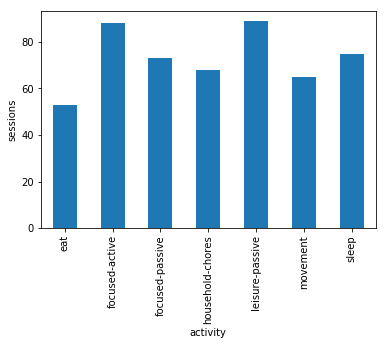

In [15]:
ac = hp.countExamplesByActivity(df)
ac.plot(kind='bar', y='# of ')

ax = ac.plot(kind='bar')
ax.set_ylabel("sessions")

### Apply scale to make all features go to mean = 0 and SD = 1. That will allow SVM kernels not to put too much weight on features with larger values.

In [16]:
#df.iloc[:, 3:15] = df.iloc[:, 3:15].apply(lambda x: scale(x))
df = hp.scaleWithinUser(df)
df.describe()

C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,user,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF
count,511.000000,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02
mean,1.189824,9.081668e-17,2.085742e-17,-1.477401e-16,-7.565160e-16,-2.137885e-16,1.807643e-16,1.194956e-17,-1.199302e-16,7.126285e-17,-4.084578e-17,-1.738118e-18,-7.549951e-17
std,0.908119,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00
min,0.000000,-2.843791e+00,-2.873066e+00,-2.547263e+00,-2.635850e+00,-2.620717e+00,-2.905886e+00,-2.207686e+00,-2.721551e+00,-1.275233e+00,-1.467678e+00,-1.552781e+00,-1.441435e+00
25%,0.000000,-7.165027e-01,-7.058184e-01,-6.671908e-01,-6.477357e-01,-5.485619e-01,-7.698206e-01,-7.580441e-01,-6.882156e-01,-5.539461e-01,-5.801241e-01,-5.796605e-01,-6.869322e-01
50%,2.000000,-4.724819e-02,-1.616980e-01,-1.033129e-01,-3.807991e-02,-1.930613e-01,-1.479614e-01,-2.320322e-01,-8.755481e-02,-3.052989e-01,-3.122527e-01,-3.218217e-01,-3.069928e-01
75%,2.000000,5.617277e-01,4.902671e-01,6.596258e-01,6.282435e-01,4.116855e-01,5.974686e-01,4.682481e-01,5.304008e-01,1.556014e-01,1.900725e-01,3.429801e-01,3.874725e-01
max,2.000000,3.960386e+00,4.527089e+00,3.880179e+00,5.022477e+00,7.809460e+00,4.081758e+00,4.073784e+00,3.766537e+00,6.320008e+00,5.711016e+00,6.086113e+00,5.772806e+00


### Test dataset will have 20% of examples, the other 80% will be for training (with cross-validation)

In [45]:
train, test = train_test_split(df, test_size=0.2)
print (len(train), len(test))

408 103


### 3 - Model selection:  Perform an exhaustive search, with k-fold cross-validation,  in the space parameter consisting of:
* $C = 10^{i}, com -1 \leq i \leq 6$, for both linear and RBF kernels
* $\gamma = 10^{i}, com -3 \leq i \leq 3$, for RBF kernel.

In [46]:
crossval = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

c_range = np.logspace(-1, 2, 4) 
gamma_range = np.logspace(-2, 1, 4)

param_lin=dict(C=c_range)
param_rbf=dict(C=c_range, gamma=gamma_range)


In [47]:
grid_lin = GridSearchCV(svm.SVC(kernel='linear', cache_size=1000), param_grid=param_lin, cv=crossval)
grid_lin.fit(X=train.iloc[:, 3:15], y=train['activity'])

print("Kernel linear --- ")
print("Best params: %s with score %0.5f" % (grid_lin.best_params_, grid_lin.best_score_))

clf1 = svm.SVC(kernel='linear', cache_size=1000, C=grid_lin.best_params_['C'])
clf1.fit(X=train.iloc[:, 3:15], y=train['activity'])
print(hp.report(test, clf1.predict(test.iloc[:, 3:15])))

Kernel linear --- 
Best params: {'C': 10.0} with score 0.42378
                  precision    recall  f1-score   support

             eat       0.25      0.38      0.30         8
  focused-active       0.32      0.33      0.32        18
 focused-passive       0.47      0.64      0.54        11
household-chores       0.43      0.21      0.29        14
 leisure-passive       0.33      0.29      0.31        17
        movement       0.73      0.65      0.69        17
           sleep       0.65      0.72      0.68        18

     avg / total       0.47      0.47      0.46       103



In [48]:
grid_rbf = GridSearchCV(svm.SVC(kernel='rbf', cache_size=1000), param_grid=param_rbf, cv=crossval)
grid_rbf.fit(X=train.iloc[:, 3:15], y=train['activity'])

print("Kernel RBF --- ")
print("Best params: %s with score %0.5f" % (grid_rbf.best_params_, grid_rbf.best_score_))

clf2 = svm.SVC(kernel='rbf', cache_size=1000, C=grid_rbf.best_params_['C'], gamma=grid_rbf.best_params_['gamma'])
clf2.fit(X=train.iloc[:, 3:15], y=train['activity'])
r_fulldf = hp.report(test, clf2.predict(test.iloc[:, 3:15]))
print(r_fulldf)

Kernel RBF --- 
Best params: {'C': 100.0, 'gamma': 0.01} with score 0.51524
                  precision    recall  f1-score   support

             eat       0.14      0.12      0.13         8
  focused-active       0.36      0.44      0.40        18
 focused-passive       0.33      0.45      0.38        11
household-chores       0.47      0.50      0.48        14
 leisure-passive       0.11      0.12      0.11        17
        movement       0.90      0.53      0.67        17
           sleep       0.69      0.61      0.65        18

     avg / total       0.46      0.42      0.43       103



[0.14, 0.12, 0.13]
[0.36, 0.44, 0.4]
[0.33, 0.45, 0.38]
[0.47, 0.5, 0.48]
[0.11, 0.12, 0.11]
[0.9, 0.53, 0.67]
[0.69, 0.61, 0.65]


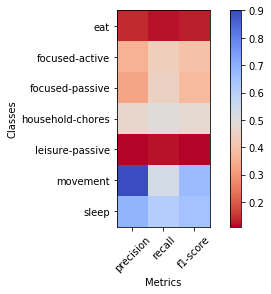

In [50]:
pr.plot_classification_report(r_fulldf, title='', with_avg_total=False, cmap=plt.cm.coolwarm_r)

In [44]:
clf3 = svm.SVC(kernel='poly', cache_size=1000, C=grid_lin.best_params_['C'])
clf3.fit(X=train.iloc[:, 3:15], y=train['activity'])
print(hp.report(test, clf3.predict(test.iloc[:, 3:15])))

                  precision    recall  f1-score   support

             eat       0.44      0.27      0.33        15
  focused-active       0.38      0.29      0.33        17
 focused-passive       0.20      0.27      0.23        11
household-chores       0.45      0.31      0.37        16
 leisure-passive       0.20      0.46      0.28        13
        movement       0.70      0.44      0.54        16
           sleep       0.87      0.87      0.87        15

     avg / total       0.48      0.42      0.43       103




## Now, we can run the same steps above with multiple experiments! Time to have fun!!

In [14]:
# exclude from df activities with too few examples

df = pd.read_csv( 'data/12features/combined.csv')
df = hp.excludeActivities(df, ['leisure-active',  'rest-active'])
print(hp.countExamplesByActivity(df))

activity
eat                 53
focused-active      88
focused-passive     73
household-chores    68
leisure-passive     89
movement            65
sleep               75
Name: user, dtype: int64


In [64]:
r = hp.runFlow(df)
print(r[0])

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


408 train examples and 103 test examples
Best params for linear kernel: {'C': 10.0} with score 0.50610
--- test results for linear kernel:
Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.50305
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.46      0.60      0.52        10
  focused-active       0.36      0.59      0.44        17
 focused-passive       0.71      0.24      0.36        21
household-chores       0.21      0.27      0.24        11
 leisure-passive       0.15      0.21      0.18        14
        movement       0.54      0.54      0.54        13
           sleep       0.88      0.41      0.56        17

     avg / total       0.51      0.40      0.41       103



In [65]:
print(r[1])

                  precision    recall  f1-score   support

             eat       0.75      0.30      0.43        10
  focused-active       0.33      0.47      0.39        17
 focused-passive       0.36      0.24      0.29        21
household-chores       0.42      0.45      0.43        11
 leisure-passive       0.14      0.21      0.17        14
        movement       0.67      0.77      0.71        13
           sleep       0.83      0.59      0.69        17

     avg / total       0.49      0.43      0.44       103



[0.75, 0.3, 0.43]
[0.33, 0.47, 0.39]
[0.36, 0.24, 0.29]
[0.42, 0.45, 0.43]
[0.14, 0.21, 0.17]
[0.67, 0.77, 0.71]
[0.83, 0.59, 0.69]


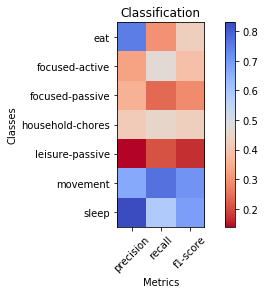

In [67]:
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

136 train examples and 35 test examples
Best params for linear kernel: {'C': 10.0} with score 0.58929
--- test results for linear kernel:


C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.58036
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.00      0.00      0.00         1
  focused-active       0.67      0.40      0.50         5
 focused-passive       0.33      0.50      0.40         4
household-chores       0.44      0.67      0.53         6
 leisure-passive       0.50      0.67      0.57         3
        movement       0.75      0.50      0.60         6
           sleep       0.89      0.80      0.84        10

     avg / total       0.63      0.60      0.60        35

                  precision    recall  f1-score   support

             eat       0.00      0.00      0.00         1
  focused-active       1.00      0.40      0.57         5
 focused-passive       0.29      0.50      0.36         4
household-chores       0.38      0.50      0.43         6
 leisure-passive       0.60      1.00      0.75         3
        movement  

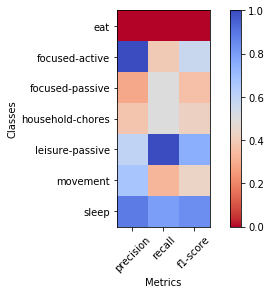

In [98]:
r0 = hp.runFlow(hp.userRows(df, 0))
print (r0[0])
print (r0[1])
pr.plot_classification_report(r0[1], title ='')


57 train examples and 15 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.66667
--- test results for linear kernel:
Best params for RBF kernel: {'C': 10.0, 'gamma': 0.01} with score 0.58333
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.50      0.50      0.50         2
 focused-active       0.71      1.00      0.83         5
leisure-passive       0.80      0.80      0.80         5
       movement       1.00      0.33      0.50         3

    avg / total       0.77      0.73      0.71        15

                 precision    recall  f1-score   support

            eat       0.33      0.50      0.40         2
 focused-active       0.80      0.80      0.80         5
leisure-passive       0.83      1.00      0.91         5
       movement       1.00      0.33      0.50         3

    avg / total       0.79      0.73      0.72        15

[0.33, 0.5, 0.4]
[0.8, 0.8, 0.8]
[0.83, 1.0, 0.91]


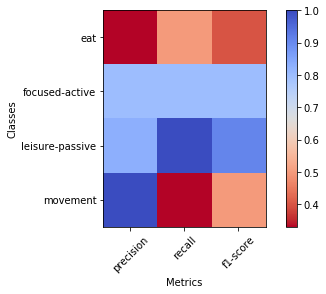

In [99]:
r1 = hp.runFlow(hp.userRows(df, 1))
print (r1[0])
print (r1[1])
pr.plot_classification_report(r1[1], title ='')

214 train examples and 54 test examples
Best params for linear kernel: {'C': 100.0} with score 0.47674
--- test results for linear kernel:
Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.58140
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.38      0.43      0.40         7
  focused-active       0.42      0.83      0.56         6
 focused-passive       0.25      0.09      0.13        11
household-chores       0.22      0.25      0.24         8
 leisure-passive       0.30      0.43      0.35         7
        movement       0.25      0.17      0.20         6
           sleep       1.00      0.78      0.88         9

     avg / total       0.41      0.41      0.39        54

                  precision    recall  f1-score   support

             eat       0.40      0.29      0.33         7
  focused-active       0.42      0.83      0.56         6
 focused-passive       0.67      0.36 

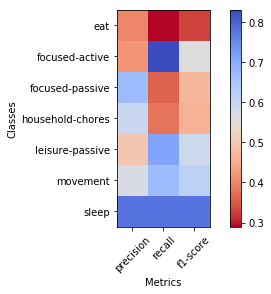

In [100]:
r2 = hp.runFlow(hp.userRows(df, 2))
print (r2[0])
print (r2[1])
pr.plot_classification_report(r2[1], title ='')

[0.25, 0.6, 0.35]
[0.57, 0.44, 0.5]
[0.44, 0.4, 0.42]
[0.5, 0.29, 0.36]
[0.14, 0.14, 0.14]
[0.43, 0.6, 0.5]
[1.0, 0.73, 0.84]


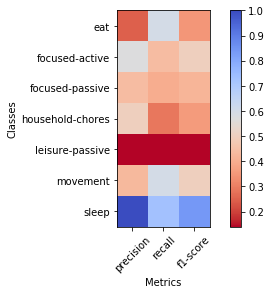

In [93]:
pr.plot_classification_report(reports[2][1], title='', cmap=plt.cm.coolwarm_r)

In [89]:
hp.countExamplesByActivity(df)

activity
eat                 53
focused-active      88
focused-passive     73
household-chores    68
leisure-passive     89
movement            65
sleep               75
Name: user, dtype: int64

### 2 - Is eating the problem??

In [102]:
df_reduced = hp.excludeActivities(df, ['eat'])
df_reduced.groupby('activity').count()['user']

activity
focused-active      88
focused-passive     73
household-chores    68
leisure-passive     89
movement            65
sleep               75
Name: user, dtype: int64

In [105]:
reduced = hp.runFlow(df_reduced)

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


366 train examples and 92 test examples
Best params for linear kernel: {'C': 1.0} with score 0.47635
--- test results for linear kernel:
                  precision    recall  f1-score   support

  focused-active       0.18      0.56      0.27         9
 focused-passive       0.67      0.43      0.52        14
household-chores       0.36      0.31      0.33        13
 leisure-passive       0.47      0.37      0.41        19
        movement       0.57      0.73      0.64        11
           sleep       0.87      0.50      0.63        26

     avg / total       0.58      0.47      0.49        92

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.50338
--- test results for RBF kernel:
                  precision    recall  f1-score   support

  focused-active       0.19      0.56      0.29         9
 focused-passive       0.46      0.43      0.44        14
household-chores       0.53      0.62      0.57        13
 leisure-passive       0.53      0.42      0.47        

In [106]:
reduced = hp.runFlowByUser(df_reduced)

131 train examples and 33 test examples
Best params for linear kernel: {'C': 1.0} with score 0.57407
--- test results for linear kernel:
                  precision    recall  f1-score   support

  focused-active       0.50      0.14      0.22         7
 focused-passive       0.33      0.43      0.38         7
household-chores       0.67      0.67      0.67         3
 leisure-passive       0.33      0.33      0.33         6
        movement       1.00      0.40      0.57         5
           sleep       0.18      0.40      0.25         5

     avg / total       0.48      0.36      0.37        33

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.56481
--- test results for RBF kernel:
                  precision    recall  f1-score   support

  focused-active       1.00      0.71      0.83         7
 focused-passive       0.44      0.57      0.50         7
household-chores       0.40      0.67      0.50         3
 leisure-passive       0.33      0.17    

C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.48649
--- test results for RBF kernel:
                  precision    recall  f1-score   support

  focused-active       0.70      0.88      0.78         8
 focused-passive       0.36      0.40      0.38        10
household-chores       0.43      0.43      0.43         7
 leisure-passive       0.17      0.20      0.18         5
        movement       0.60      0.33      0.43         9
           sleep       0.88      0.88      0.88         8

     avg / total       0.54      0.53      0.53        47



### 2 - Splitting database into movement categories (movement, household chores and exercise) and all others

In [107]:
includelist = ['movement', 'household-chores']

df_move = hp.addPartition(df, includelist, pname='move', labelIn='move', labelOut='still')
df_move.groupby('move').count()['user']

move
move     133
still    378
Name: user, dtype: int64

In [175]:
mvres = hp.runFlow(df_move, labelName='move')

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


408 train examples and 103 test examples
Best params for linear kernel: {'C': 1.0} with score 0.90244
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       0.80      0.52      0.63        23
      still       0.88      0.96      0.92        80

avg / total       0.86      0.86      0.85       103

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.89024
--- test results for RBF kernel:
             precision    recall  f1-score   support

       move       0.80      0.52      0.63        23
      still       0.88      0.96      0.92        80

avg / total       0.86      0.86      0.85       103



[0.95, 0.72, 0.82]
[0.92, 0.99, 0.95]


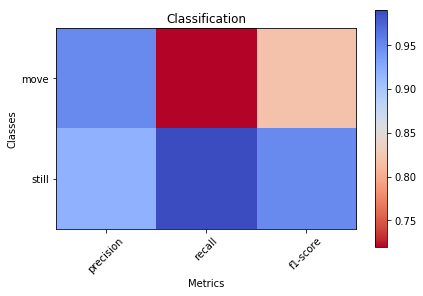

In [111]:
pr.plot_classification_report(mvres[0])

In [130]:
mvresu = hp.runFlowByUser(df_move, labelName='move')

136 train examples and 35 test examples
Best params for linear kernel: {'C': 1.0} with score 0.87500
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       0.73      0.85      0.79        13
      still       0.90      0.82      0.86        22

avg / total       0.84      0.83      0.83        35

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.92857
--- test results for RBF kernel:
             precision    recall  f1-score   support

       move       0.85      0.85      0.85        13
      still       0.91      0.91      0.91        22

avg / total       0.89      0.89      0.89        35

57 train examples and 15 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.95833
--- test results for linear kernel:
             precision    recall  f1-score   support

      still       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00        1

In [136]:
scores = []
for i in mvresu:
    scores.append(pr.fscore_from_report(i)) 
print(scores)

['0.89', '1.00', '0.85']


'0.91'

## Hierarchy

### 1 - Split data by movement intensity:
 * group 1 = movement, household chores, exercise
 

In [142]:
df_stillcls = hp.excludeActivities(df, includelist)
hp.countExamplesByActivity(df_stillcls)

activity
eat                53
focused-active     88
focused-passive    73
leisure-passive    89
sleep              75
Name: user, dtype: int64

In [143]:
hp.runFlow(df_stillcls)

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


302 train examples and 76 test examples
Best params for linear kernel: {'C': 0.01} with score 0.43033
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         9
 focused-active       0.34      0.81      0.48        16
focused-passive       0.24      0.45      0.31        11
leisure-passive       0.50      0.08      0.13        26
          sleep       0.46      0.43      0.44        14

    avg / total       0.36      0.34      0.27        76



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.49180
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.35      0.67      0.46         9
 focused-active       0.48      0.62      0.54        16
focused-passive       0.33      0.27      0.30        11
leisure-passive       0.56      0.38      0.45        26
          sleep       0.64      0.50      0.56        14

    avg / total       0.50      0.47      0.47        76



['                 precision    recall  f1-score   support\n\n            eat       0.00      0.00      0.00         9\n focused-active       0.34      0.81      0.48        16\nfocused-passive       0.24      0.45      0.31        11\nleisure-passive       0.50      0.08      0.13        26\n          sleep       0.46      0.43      0.44        14\n\n    avg / total       0.36      0.34      0.27        76\n',
 '                 precision    recall  f1-score   support\n\n            eat       0.35      0.67      0.46         9\n focused-active       0.48      0.62      0.54        16\nfocused-passive       0.33      0.27      0.30        11\nleisure-passive       0.56      0.38      0.45        26\n          sleep       0.64      0.50      0.56        14\n\n    avg / total       0.50      0.47      0.47        76\n']

In [144]:
hp.runFlowByUser(df_stillcls)

92 train examples and 24 test examples
Best params for linear kernel: {'C': 10.0} with score 0.55263
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.50      0.75      0.60         4
focused-passive       0.86      0.60      0.71        10
leisure-passive       0.60      0.75      0.67         4
          sleep       0.60      0.50      0.55         6

    avg / total       0.69      0.62      0.64        24



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 1.0} with score 0.53947
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.50      0.25      0.33         4
focused-passive       0.86      0.60      0.71        10
leisure-passive       0.67      1.00      0.80         4
          sleep       0.50      0.67      0.57         6

    avg / total       0.68      0.62      0.63        24

51 train examples and 13 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.65909
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       1.00      0.67      0.80         3
 focused-active       0.60      0.60      0.60         5
leisure-passive       0.67      0.80      0.73         5

    avg / total       0.72      0.69      0.70        13



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best params for RBF kernel: {'C': 0.01, 'gamma': 0.10000000000000001} with score 0.75000
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         3
 focused-active       0.50      0.80      0.62         5
leisure-passive       0.80      0.80      0.80         5

    avg / total       0.50      0.62      0.54        13

158 train examples and 40 test examples


C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for linear kernel: {'C': 100.0} with score 0.50000
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.55      1.00      0.71         6
 focused-active       0.43      0.60      0.50         5
focused-passive       0.80      0.50      0.62         8
leisure-passive       0.50      0.33      0.40         6
          sleep       1.00      0.87      0.93        15

    avg / total       0.75      0.70      0.70        40

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.60156
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.33      0.50      0.40         6
 focused-active       0.50      0.60      0.55         5
focused-passive       0.83      0.62      0.71         8
leisure-passive       0.57      0.67      0.62         6
          sleep       1.00      0.80      0.89        15

    avg / total       0.74      

[['                 precision    recall  f1-score   support\n\n            eat       0.00      0.00      0.00         0\n focused-active       0.50      0.75      0.60         4\nfocused-passive       0.86      0.60      0.71        10\nleisure-passive       0.60      0.75      0.67         4\n          sleep       0.60      0.50      0.55         6\n\n    avg / total       0.69      0.62      0.64        24\n',
  '                 precision    recall  f1-score   support\n\n            eat       0.00      0.00      0.00         0\n focused-active       0.50      0.25      0.33         4\nfocused-passive       0.86      0.60      0.71        10\nleisure-passive       0.67      1.00      0.80         4\n          sleep       0.50      0.67      0.57         6\n\n    avg / total       0.68      0.62      0.63        24\n'],
 ['                 precision    recall  f1-score   support\n\n            eat       1.00      0.67      0.80         3\n focused-active       0.60      0.60      0.60

In [176]:
df_movecls = hp.filterActivities(df, includelist)
hp.countExamplesByActivity(df_movecls)

activity
household-chores    68
movement            65
Name: user, dtype: int64

In [177]:
hp.runFlow(df_movecls)

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


106 train examples and 27 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.62500
--- test results for linear kernel:
                  precision    recall  f1-score   support

household-chores       0.50      0.82      0.62        11
        movement       0.78      0.44      0.56        16

     avg / total       0.66      0.59      0.58        27

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.10000000000000001} with score 0.64773
--- test results for RBF kernel:
                  precision    recall  f1-score   support

household-chores       0.52      1.00      0.69        11
        movement       1.00      0.38      0.55        16

     avg / total       0.81      0.63      0.60        27



['                  precision    recall  f1-score   support\n\nhousehold-chores       0.50      0.82      0.62        11\n        movement       0.78      0.44      0.56        16\n\n     avg / total       0.66      0.59      0.58        27\n',
 '                  precision    recall  f1-score   support\n\nhousehold-chores       0.52      1.00      0.69        11\n        movement       1.00      0.38      0.55        16\n\n     avg / total       0.81      0.63      0.60        27\n']

In [196]:
ju_move = hp.userRows(df_movecls, 0)
print(hp.countExamplesByActivity(ju_move))
hp.runFlow(ju_move)

activity
household-chores    28
movement            27
Name: user, dtype: int64
44 train examples and 11 test examples
Best params for linear kernel: {'C': 10.0} with score 0.72222
--- test results for linear kernel:
                  precision    recall  f1-score   support

household-chores       0.62      0.71      0.67         7
        movement       0.33      0.25      0.29         4

     avg / total       0.52      0.55      0.53        11

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.10000000000000001} with score 0.69444
--- test results for RBF kernel:
                  precision    recall  f1-score   support

household-chores       0.86      0.86      0.86         7
        movement       0.75      0.75      0.75         4

     avg / total       0.82      0.82      0.82        11



['                  precision    recall  f1-score   support\n\nhousehold-chores       0.62      0.71      0.67         7\n        movement       0.33      0.25      0.29         4\n\n     avg / total       0.52      0.55      0.53        11\n',
 '                  precision    recall  f1-score   support\n\nhousehold-chores       0.86      0.86      0.86         7\n        movement       0.75      0.75      0.75         4\n\n     avg / total       0.82      0.82      0.82        11\n']

In [197]:
edu_move = hp.userRows(df_movecls, 2)
print(hp.countExamplesByActivity(edu_move))
hp.runFlow(edu_move)

activity
household-chores    40
movement            30
Name: user, dtype: int64
56 train examples and 14 test examples
Best params for linear kernel: {'C': 0.01} with score 0.58333
--- test results for linear kernel:
                  precision    recall  f1-score   support

household-chores       0.50      1.00      0.67         7
        movement       0.00      0.00      0.00         7

     avg / total       0.25      0.50      0.33        14



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.66667
--- test results for RBF kernel:
                  precision    recall  f1-score   support

household-chores       0.56      0.71      0.63         7
        movement       0.60      0.43      0.50         7

     avg / total       0.58      0.57      0.56        14



['                  precision    recall  f1-score   support\n\nhousehold-chores       0.50      1.00      0.67         7\n        movement       0.00      0.00      0.00         7\n\n     avg / total       0.25      0.50      0.33        14\n',
 '                  precision    recall  f1-score   support\n\nhousehold-chores       0.56      0.71      0.63         7\n        movement       0.60      0.43      0.50         7\n\n     avg / total       0.58      0.57      0.56        14\n']

In [195]:
for activ in df_stillcls.activity.unique():
    print ('----------------------------------------------------------------')
    dfa = df_stillcls
    df_onevsall = hp.addPartition(df=dfa, includelist=[activ], pname=activ, labelIn=activ, labelOut='others')
    print(df_onevsall.groupby(activ).count()['user'])
    hp.runFlow(df_onevsall, labelName=activ)

----------------------------------------------------------------
eat
eat        53
others    325
Name: user, dtype: int64


C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


302 train examples and 76 test examples
Best params for linear kernel: {'C': 0.01} with score 0.86885
--- test results for linear kernel:
             precision    recall  f1-score   support

        eat       0.00      0.00      0.00        11
     others       0.86      1.00      0.92        65

avg / total       0.73      0.86      0.79        76



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.89344
--- test results for RBF kernel:
             precision    recall  f1-score   support

        eat       0.50      0.27      0.35        11
     others       0.89      0.95      0.92        65

avg / total       0.83      0.86      0.84        76

----------------------------------------------------------------
focused-active
focused-active     88
others            290
Name: user, dtype: int64


C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


302 train examples and 76 test examples
Best params for linear kernel: {'C': 0.01} with score 0.77049
--- test results for linear kernel:
                precision    recall  f1-score   support

focused-active       0.00      0.00      0.00        20
        others       0.74      1.00      0.85        56

   avg / total       0.54      0.74      0.63        76



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.81557
--- test results for RBF kernel:
                precision    recall  f1-score   support

focused-active       0.56      0.25      0.34        20
        others       0.78      0.93      0.85        56

   avg / total       0.72      0.75      0.71        76

----------------------------------------------------------------
focused-passive
focused-passive     73
others             305
Name: user, dtype: int64


C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


302 train examples and 76 test examples
Best params for linear kernel: {'C': 0.01} with score 0.81967
--- test results for linear kernel:
                 precision    recall  f1-score   support

focused-passive       0.00      0.00      0.00        17
         others       0.78      1.00      0.87        59

    avg / total       0.60      0.78      0.68        76



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 1.0, 'gamma': 1.0} with score 0.83197
--- test results for RBF kernel:
                 precision    recall  f1-score   support

focused-passive       1.00      0.06      0.11        17
         others       0.79      1.00      0.88        59

    avg / total       0.83      0.79      0.71        76

----------------------------------------------------------------
leisure-passive
leisure-passive     89
others             289
Name: user, dtype: int64


C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


302 train examples and 76 test examples
Best params for linear kernel: {'C': 0.01} with score 0.77049
--- test results for linear kernel:
                 precision    recall  f1-score   support

leisure-passive       0.00      0.00      0.00        22
         others       0.71      1.00      0.83        54

    avg / total       0.50      0.71      0.59        76



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 0.01, 'gamma': 0.01} with score 0.77049
--- test results for RBF kernel:
                 precision    recall  f1-score   support

leisure-passive       0.00      0.00      0.00        22
         others       0.71      1.00      0.83        54

    avg / total       0.50      0.71      0.59        76

----------------------------------------------------------------
sleep
others    303
sleep      75
Name: user, dtype: int64


C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


302 train examples and 76 test examples
Best params for linear kernel: {'C': 100.0} with score 0.85656
--- test results for linear kernel:
             precision    recall  f1-score   support

     others       0.94      0.97      0.95        64
      sleep       0.80      0.67      0.73        12

avg / total       0.92      0.92      0.92        76

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.86885
--- test results for RBF kernel:
             precision    recall  f1-score   support

     others       0.98      0.97      0.98        64
      sleep       0.85      0.92      0.88        12

avg / total       0.96      0.96      0.96        76



### Split still activities by sleep vc others

In [158]:
hp.countExamplesByActivity(df_stillcls)
df_partsleep = hp.addPartition(df=df_stillcls, includelist=['sleep'], pname='sleep', labelIn='sleep', labelOut='wake')
print(df_partsleep.groupby('sleep').count()['user'])

sleep
sleep     75
wake     303
Name: user, dtype: int64


In [159]:
 hp.runFlow(df_partsleep, labelName='sleep')

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


302 train examples and 76 test examples
Best params for linear kernel: {'C': 1.0} with score 0.86066
--- test results for linear kernel:
             precision    recall  f1-score   support

      sleep       0.62      0.45      0.53        11
       wake       0.91      0.95      0.93        65

avg / total       0.87      0.88      0.87        76

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.86066
--- test results for RBF kernel:
             precision    recall  f1-score   support

      sleep       0.60      0.82      0.69        11
       wake       0.97      0.91      0.94        65

avg / total       0.91      0.89      0.90        76



['             precision    recall  f1-score   support\n\n      sleep       0.62      0.45      0.53        11\n       wake       0.91      0.95      0.93        65\n\navg / total       0.87      0.88      0.87        76\n',
 '             precision    recall  f1-score   support\n\n      sleep       0.60      0.82      0.69        11\n       wake       0.97      0.91      0.94        65\n\navg / total       0.91      0.89      0.90        76\n']

In [162]:
ju_sleep = hp.userRows(df_partsleep, 0) 
hp.runFlow(ju_sleep, labelName='sleep')

92 train examples and 24 test examples
Best params for linear kernel: {'C': 10.0} with score 0.84211
--- test results for linear kernel:
             precision    recall  f1-score   support

      sleep       0.80      0.80      0.80        10
       wake       0.86      0.86      0.86        14

avg / total       0.83      0.83      0.83        24

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.88158
--- test results for RBF kernel:
             precision    recall  f1-score   support

      sleep       0.78      0.70      0.74        10
       wake       0.80      0.86      0.83        14

avg / total       0.79      0.79      0.79        24



['             precision    recall  f1-score   support\n\n      sleep       0.80      0.80      0.80        10\n       wake       0.86      0.86      0.86        14\n\navg / total       0.83      0.83      0.83        24\n',
 '             precision    recall  f1-score   support\n\n      sleep       0.78      0.70      0.74        10\n       wake       0.80      0.86      0.83        14\n\navg / total       0.79      0.79      0.79        24\n']

In [163]:
edu_sleep = hp.userRows(df_partsleep, 2) 
hp.runFlow(edu_sleep, labelName='sleep')

158 train examples and 40 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.96875
--- test results for linear kernel:
             precision    recall  f1-score   support

      sleep       1.00      0.89      0.94         9
       wake       0.97      1.00      0.98        31

avg / total       0.98      0.97      0.97        40

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.01} with score 0.98438
--- test results for RBF kernel:
             precision    recall  f1-score   support

      sleep       1.00      0.89      0.94         9
       wake       0.97      1.00      0.98        31

avg / total       0.98      0.97      0.97        40



['             precision    recall  f1-score   support\n\n      sleep       1.00      0.89      0.94         9\n       wake       0.97      1.00      0.98        31\n\navg / total       0.98      0.97      0.97        40\n',
 '             precision    recall  f1-score   support\n\n      sleep       1.00      0.89      0.94         9\n       wake       0.97      1.00      0.98        31\n\navg / total       0.98      0.97      0.97        40\n']

In [164]:
df_wake = hp.excludeActivities(df_stillcls,['sleep'] )
hp.countExamplesByActivity(df_wake)

activity
eat                53
focused-active     88
focused-passive    73
leisure-passive    89
Name: user, dtype: int64

In [165]:
hp.runFlow(df_wake)

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


242 train examples and 61 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.40816
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.30      0.23      0.26        13
 focused-active       0.67      0.45      0.54        22
focused-passive       0.13      0.22      0.17         9
leisure-passive       0.38      0.47      0.42        17

    avg / total       0.43      0.38      0.39        61

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.53061
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.27      0.31      0.29        13
 focused-active       0.59      0.45      0.51        22
focused-passive       0.19      0.33      0.24         9
leisure-passive       0.31      0.24      0.27        17

    avg / total       0.38      0.34      0.36        61



['                 precision    recall  f1-score   support\n\n            eat       0.30      0.23      0.26        13\n focused-active       0.67      0.45      0.54        22\nfocused-passive       0.13      0.22      0.17         9\nleisure-passive       0.38      0.47      0.42        17\n\n    avg / total       0.43      0.38      0.39        61\n',
 '                 precision    recall  f1-score   support\n\n            eat       0.27      0.31      0.29        13\n focused-active       0.59      0.45      0.51        22\nfocused-passive       0.19      0.33      0.24         9\nleisure-passive       0.31      0.24      0.27        17\n\n    avg / total       0.38      0.34      0.36        61\n']

In [166]:
hp.runFlowByUser(df_wake)

67 train examples and 17 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.57143
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         2
 focused-active       0.00      0.00      0.00         5
focused-passive       0.53      1.00      0.70         8
leisure-passive       1.00      1.00      1.00         2

    avg / total       0.37      0.59      0.45        17



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.01} with score 0.53571
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         2
 focused-active       0.00      0.00      0.00         5
focused-passive       0.53      1.00      0.70         8
leisure-passive       1.00      1.00      1.00         2

    avg / total       0.37      0.59      0.45        17

51 train examples and 13 test examples
Best params for linear kernel: {'C': 100.0} with score 0.72727
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.50      0.50      0.50         2
 focused-active       0.78      0.88      0.82         8
leisure-passive       1.00      0.67      0.80         3

    avg / total       0.79      0.77      0.77        13



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.63636
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.33      0.50      0.40         2
 focused-active       0.83      0.62      0.71         8
leisure-passive       0.50      0.67      0.57         3

    avg / total       0.68      0.62      0.63        13

124 train examples and 31 test examples
Best params for linear kernel: {'C': 1.0} with score 0.46000
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.22      0.40      0.29         5
 focused-active       0.67      0.67      0.67        12
focused-passive       0.50      0.33      0.40         6
leisure-passive       0.00      0.00      0.00         8

    avg / total       0.39      0.39      0.38        31

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.52000
--- test results fo

[['                 precision    recall  f1-score   support\n\n            eat       0.00      0.00      0.00         2\n focused-active       0.00      0.00      0.00         5\nfocused-passive       0.53      1.00      0.70         8\nleisure-passive       1.00      1.00      1.00         2\n\n    avg / total       0.37      0.59      0.45        17\n',
  '                 precision    recall  f1-score   support\n\n            eat       0.00      0.00      0.00         2\n focused-active       0.00      0.00      0.00         5\nfocused-passive       0.53      1.00      0.70         8\nleisure-passive       1.00      1.00      1.00         2\n\n    avg / total       0.37      0.59      0.45        17\n'],
 ['                 precision    recall  f1-score   support\n\n            eat       0.50      0.50      0.50         2\n focused-active       0.78      0.88      0.82         8\nleisure-passive       1.00      0.67      0.80         3\n\n    avg / total       0.79      0.77      0.

### Split by passive vs active sitting activities

In [167]:
df_actlvl = hp.addPartition(df_wake, includelist=['focused-passive', 'leisure-passive'], pname='actlvl', labelIn='passive', labelOut='active')
print(df_passive.groupby('actlvl').count()['user'])

NameError: name 'df_passive' is not defined

In [170]:
hp.runFlow(df_actlvl, labelName='actlvl')

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


242 train examples and 61 test examples
Best params for linear kernel: {'C': 1.0} with score 0.62755
--- test results for linear kernel:
             precision    recall  f1-score   support

     active       0.75      0.43      0.55        28
    passive       0.64      0.88      0.74        33

avg / total       0.69      0.67      0.65        61

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.69898
--- test results for RBF kernel:
             precision    recall  f1-score   support

     active       0.69      0.71      0.70        28
    passive       0.75      0.73      0.74        33

avg / total       0.72      0.72      0.72        61



['             precision    recall  f1-score   support\n\n     active       0.75      0.43      0.55        28\n    passive       0.64      0.88      0.74        33\n\navg / total       0.69      0.67      0.65        61\n',
 '             precision    recall  f1-score   support\n\n     active       0.69      0.71      0.70        28\n    passive       0.75      0.73      0.74        33\n\navg / total       0.72      0.72      0.72        61\n']

In [171]:
hp.runFlowByUser(df_actlvl, labelName='actlvl')

67 train examples and 17 test examples
Best params for linear kernel: {'C': 0.01} with score 0.71429
--- test results for linear kernel:
             precision    recall  f1-score   support

     active       0.00      0.00      0.00         7
    passive       0.59      1.00      0.74        10

avg / total       0.35      0.59      0.44        17



C:\Users\johndoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.83929
--- test results for RBF kernel:
             precision    recall  f1-score   support

     active       1.00      0.29      0.44         7
    passive       0.67      1.00      0.80        10

avg / total       0.80      0.71      0.65        17

51 train examples and 13 test examples
Best params for linear kernel: {'C': 1.0} with score 0.77273
--- test results for linear kernel:
             precision    recall  f1-score   support

     active       0.71      0.62      0.67         8
    passive       0.50      0.60      0.55         5

avg / total       0.63      0.62      0.62        13

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.68182
--- test results for RBF kernel:
             precision    recall  f1-score   support

     active       0.75      0.75      0.75         8
    passive       0.60      0.60      0.60         5

avg / total       0.69      0

[['             precision    recall  f1-score   support\n\n     active       0.00      0.00      0.00         7\n    passive       0.59      1.00      0.74        10\n\navg / total       0.35      0.59      0.44        17\n',
  '             precision    recall  f1-score   support\n\n     active       1.00      0.29      0.44         7\n    passive       0.67      1.00      0.80        10\n\navg / total       0.80      0.71      0.65        17\n'],
 ['             precision    recall  f1-score   support\n\n     active       0.71      0.62      0.67         8\n    passive       0.50      0.60      0.55         5\n\navg / total       0.63      0.62      0.62        13\n',
  '             precision    recall  f1-score   support\n\n     active       0.75      0.75      0.75         8\n    passive       0.60      0.60      0.60         5\n\navg / total       0.69      0.69      0.69        13\n'],
 ['             precision    recall  f1-score   support\n\n     active       0.55      0.38   

In [172]:
df_passive = hp.filterActivities(df_actlvl, ['leisure-passive', 'focused-passive'])
hp.countExamplesByActivity(df_passive)

activity
focused-passive    73
leisure-passive    89
Name: user, dtype: int64

In [173]:
hp.runFlow(df_passive)

C:\Users\johndoe\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


129 train examples and 33 test examples
Best params for linear kernel: {'C': 10.0} with score 0.72115
--- test results for linear kernel:
                 precision    recall  f1-score   support

focused-passive       0.44      0.58      0.50        12
leisure-passive       0.71      0.57      0.63        21

    avg / total       0.61      0.58      0.58        33

Best params for RBF kernel: {'C': 1.0, 'gamma': 1.0} with score 0.61538
--- test results for RBF kernel:
                 precision    recall  f1-score   support

focused-passive       0.62      0.42      0.50        12
leisure-passive       0.72      0.86      0.78        21

    avg / total       0.69      0.70      0.68        33



['                 precision    recall  f1-score   support\n\nfocused-passive       0.44      0.58      0.50        12\nleisure-passive       0.71      0.57      0.63        21\n\n    avg / total       0.61      0.58      0.58        33\n',
 '                 precision    recall  f1-score   support\n\nfocused-passive       0.62      0.42      0.50        12\nleisure-passive       0.72      0.86      0.78        21\n\n    avg / total       0.69      0.70      0.68        33\n']

In [174]:
hp.runFlow(hp.userRows(df_passive, 0))

44 train examples and 12 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.86111
--- test results for linear kernel:
                 precision    recall  f1-score   support

focused-passive       0.88      0.78      0.82         9
leisure-passive       0.50      0.67      0.57         3

    avg / total       0.78      0.75      0.76        12

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.10000000000000001} with score 0.83333
--- test results for RBF kernel:
                 precision    recall  f1-score   support

focused-passive       0.88      0.78      0.82         9
leisure-passive       0.50      0.67      0.57         3

    avg / total       0.78      0.75      0.76        12



['                 precision    recall  f1-score   support\n\nfocused-passive       0.88      0.78      0.82         9\nleisure-passive       0.50      0.67      0.57         3\n\n    avg / total       0.78      0.75      0.76        12\n',
 '                 precision    recall  f1-score   support\n\nfocused-passive       0.88      0.78      0.82         9\nleisure-passive       0.50      0.67      0.57         3\n\n    avg / total       0.78      0.75      0.76        12\n']

In [144]:
hp.runFlow(hp.userRows(df_passive, 2))

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


63 train examples and 16 test examples
Best params for linear kernel: {'C': 10.0} with score 0.55769
--- test results for linear kernel:
                 precision    recall  f1-score   support

focused-passive       0.75      0.27      0.40        11
leisure-passive       0.33      0.80      0.47         5

    avg / total       0.62      0.44      0.42        16

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.01} with score 0.63462
--- test results for RBF kernel:
                 precision    recall  f1-score   support

focused-passive       1.00      0.09      0.17        11
leisure-passive       0.33      1.00      0.50         5

    avg / total       0.79      0.38      0.27        16



In [131]:
df_active = hp.excludeActivities(df_actlvl, ['leisure-passive', 'focused-passive'])
hp.countExamplesByActivity(df_active)

activity
eat               53
focused-active    88
Name: user, dtype: int64

In [145]:
hp.runFlow(df_active)

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\julia\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


112 train examples and 29 test examples
Best params for linear kernel: {'C': 100.0} with score 0.89130
--- test results for linear kernel:
                precision    recall  f1-score   support

           eat       0.78      0.64      0.70        11
focused-active       0.80      0.89      0.84        18

   avg / total       0.79      0.79      0.79        29

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.01} with score 0.83696
--- test results for RBF kernel:
                precision    recall  f1-score   support

           eat       0.78      0.64      0.70        11
focused-active       0.80      0.89      0.84        18

   avg / total       0.79      0.79      0.79        29



In [149]:
hp.runFlowByUser(df_active)

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\julia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CLASSFIER FOR USER 0
22 train examples and 6 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.85000
--- test results for linear kernel:
                precision    recall  f1-score   support

           eat       0.00      0.00      0.00         1
focused-active       0.83      1.00      0.91         5

   avg / total       0.69      0.83      0.76         6

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.10000000000000001} with score 0.90000
--- test results for RBF kernel:
                precision    recall  f1-score   support

           eat       0.00      0.00      0.00         1
focused-active       0.83      1.00      0.91         5

   avg / total       0.69      0.83      0.76         6

CLASSFIER FOR USER 1
29 train examples and 8 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.87500
--- test results for linear kernel:
                precision    recall  f1-score   support

           eat       1.0

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Best params for RBF kernel: {'C': 1.0, 'gamma': 0.10000000000000001} with score 0.95833
--- test results for RBF kernel:
                precision    recall  f1-score   support

           eat       1.00      0.50      0.67         2
focused-active       0.86      1.00      0.92         6

   avg / total       0.89      0.88      0.86         8

CLASSFIER FOR USER 2
60 train examples and 16 test examples
Best params for linear kernel: {'C': 1.0} with score 0.72917
--- test results for linear kernel:
                precision    recall  f1-score   support

           eat       1.00      0.83      0.91         6
focused-active       0.91      1.00      0.95        10

   avg / total       0.94      0.94      0.94        16



C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.01} with score 0.79167
--- test results for RBF kernel:
                precision    recall  f1-score   support

           eat       0.75      0.50      0.60         6
focused-active       0.75      0.90      0.82        10

   avg / total       0.75      0.75      0.74        16

